# Image classification with ConvMixer

<hr />

### Introduction

Vision Transformers (ViT; <a href="https://arxiv.org/abs/1612.00593">Dosovitskiy et al.</a>) extract small patches from the input images, linearly project them, and then apply the Transformer (<a href="https://arxiv.org/abs/1706.03762">Vaswani et al.</a>) blocks. The application of ViTs to image recognition tasks is quickly becoming a promising area of research, because ViTs eliminate the need to have strong inductive biases (such as convolutions) for modeling locality. This presents them as a general computation primititive capable of learning just from the training data with as minimal inductive priors as possible. ViTs yield great downstream performance when trained with proper regularization, data augmentation, and relatively large datasets.

In the <a href="https://openreview.net/pdf?id=TVHS5Y4dNvM">Patches Are All You Need</a> paper (note: at the time of writing, it is a submission to the ICLR 2022 conference), the authors extend the idea of using patches to train an all-convolutional network and demonstrate competitive results. Their architecture namely <b>ConvMixer</b> uses recipes from the recent isotrophic architectures like ViT, MLP-Mixer (<a href="https://arxiv.org/abs/2105.01601">Tolstikhin et al.</a>), such as using the same depth and resolution across different layers in the network, residual connections, and so on.

In this example, we will implement the ConvMixer model and demonstrate its performance on the CIFAR-10 dataset.

<hr />

### Imports

In [1]:
import keras
from keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

2025-04-21 04:51:03.900037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745211063.915648  105436 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745211063.920650  105436 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745211063.931585  105436 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745211063.931600  105436 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745211063.931602  105436 computation_placer.cc:177] computation placer alr

<hr />

### Hyperparameters

To keep run time short, we will train the model for only 10 epochs. To focus on the core ideas of ConvMixer, we will not use other training-specific elements like RandAugment (<a href="https://arxiv.org/abs/1909.13719">Cubuk et al.</a>). If you are interested in learning more about those details, please refer to the <a href="https://openreview.net/pdf?id=TVHS5Y4dNvM">original paper</a>.

In [2]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10

<hr />

### Load the CIFAR-10 dataset

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
val_split = 0.1

val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


<hr />

### Prepare <a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset">tf.data.Dataset</a> objects

Our data augmentation pipeline is different from what the authors used for the CIFAR-10 dataset, which is fine for the purpose of the example. Note that, it's ok to use <b>TF APIs for data I/O and preprocessing</b> with other backends (jax, torch) as it is feature-complete framework when it comes to data preprocessing.

In [4]:
image_size = 32
auto = tf.data.AUTOTUNE

augmentation_layers = [
    keras.layers.RandomCrop(image_size, image_size),
    keras.layers.RandomFlip("horizontal"),
]


def augment_images(images):
    for layer in augmentation_layers:
        images = layer(images, training=True)
    return images


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (augment_images(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)


train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

2025-04-21 04:53:37.736305: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<hr />

### ConvMixer utilities

The following figure (taken from the original paper) depicts the ConvMixer model:

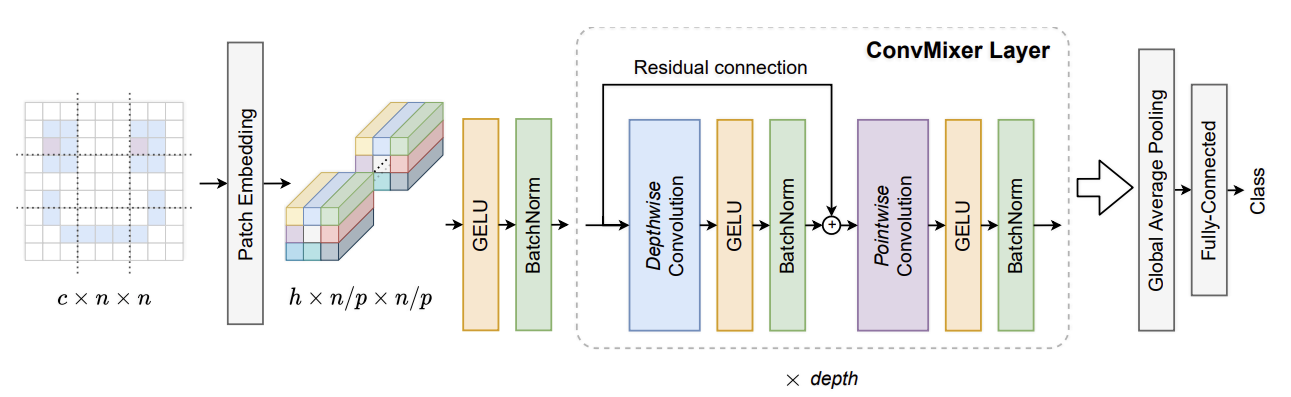

ConvMixer is very similar to the MLP-Mixer, model with the following key differences:

<ul>
    <li>Instead of using fully-connected layers, it uses standard convolution layers.</li>
    <li>Instead of LayerNorm (which is typical for ViTs and MLP-Mixers), it uses BatchNorm.</li>
</ul>

Two types of convolution layers are used in ConvMixer. <b>(1):</b> Depthwise convolutions, for mixing spatial locations of the images, <b>(2):</b> Pointwise convolutions (which follow the depthwise convolutions), for mixing channel-wise information across the patches. Another keypoint is the use of larger kernel sizes to allow a larger receptive field.

In [5]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

The model used in this experiment is termed as <b>ConvMixer-256/8</b> where 256 denotes the number of channels and 8 denotes the depth. The resulting model only has 0.8 million parameters.

<hr />

### Model training and evaluation utility

In [6]:
# Code reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/.


def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint.keras"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

<hr />

### Train and evaluate model

In [7]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1309s 4s/step - accuracy: 0.4565 - loss: 1.4874 - val_accuracy: 0.1038 - val_loss: 5.0935
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1291s 4s/step - accuracy: 0.6925 - loss: 0.8633 - val_accuracy: 0.7188 - val_loss: 0.8129
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1303s 4s/step - accuracy: 0.7760 - loss: 0.6447 - val_accuracy: 0.7718 - val_loss: 0.7033
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1292s 4s/step - accuracy: 0.8206 - loss: 0.5105 - val_accuracy: 0.7842 - val_loss: 0.6685
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1295s 4s/step - accuracy: 0.8551 - loss: 0.4198 - val_accuracy: 0.8150 - val_loss: 0.5925
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1294s 4s/step - accuracy: 0.8762 - loss: 0.3594 - val_accuracy: 0.8156 - val_loss: 0.5913
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1295s 4s/step - accuracy: 0.8918 - loss: 0.3106 - val_accuracy: 0.8278 - val_loss: 0.5479
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1292s 4s/step - accuracy: 0.9101 - loss: 0.2639 - 

The gap in training and validation performance can be mitigated by using additional regularization techniques. Nevertheless, being able to get to ~83% accuracy within 10 epochs with 0.8 million parameters is a strong result.

<hr />

### Visualizing the internals of ConvMixer

We can visualize the patch embeddings and the learned convolution filters. Recall that each patch embedding and intermediate feature map have the same number of channels (256 in this case). This will make our visualization utility easier to implement.

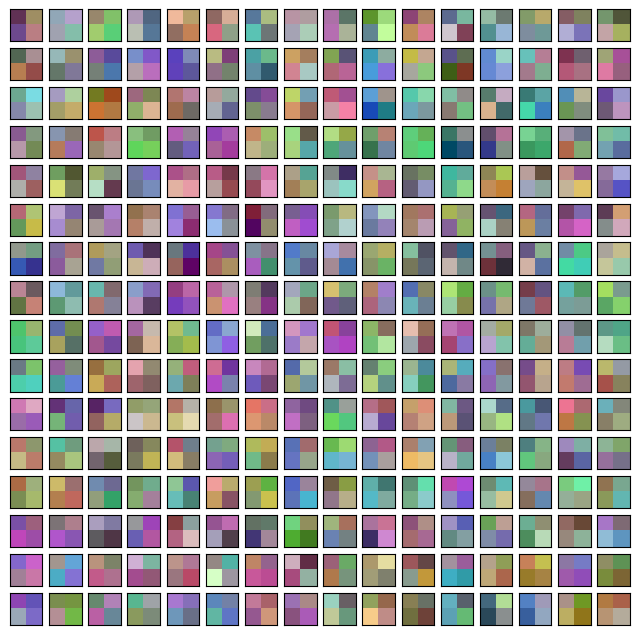

In [8]:
# Code reference: https://bit.ly/3awIRbP.


def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

Even though we did not train the network to convergence, we can notice that different patches show different patterns. Some share similarity with others while some are very different. These visualizations are more salient with larger image sizes.

Similarly, we can visualize the raw convolution kernels. This can help us understand the patterns to which a given kernel is receptive.

5 <DepthwiseConv2D name=depthwise_conv2d, built=True>
12 <DepthwiseConv2D name=depthwise_conv2d_1, built=True>
19 <DepthwiseConv2D name=depthwise_conv2d_2, built=True>
26 <DepthwiseConv2D name=depthwise_conv2d_3, built=True>
33 <DepthwiseConv2D name=depthwise_conv2d_4, built=True>
40 <DepthwiseConv2D name=depthwise_conv2d_5, built=True>
47 <DepthwiseConv2D name=depthwise_conv2d_6, built=True>
54 <DepthwiseConv2D name=depthwise_conv2d_7, built=True>


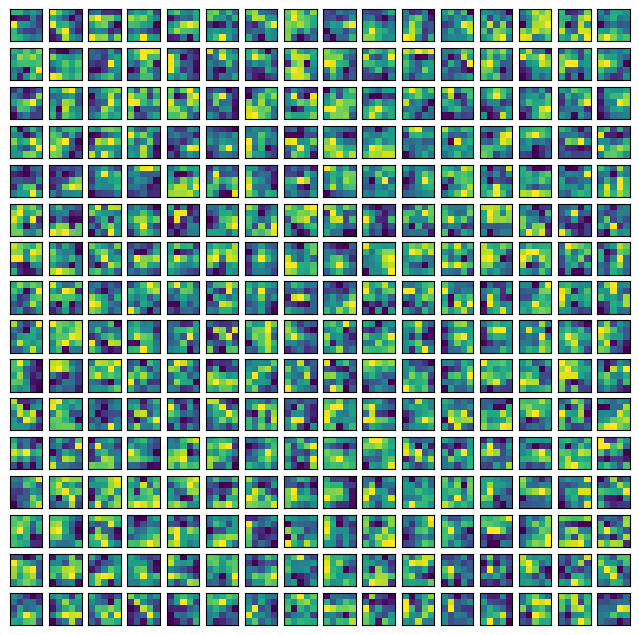

In [9]:
# First, print the indices of the convolution layers that are not
# pointwise convolutions.
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)

We see that different filters in the kernel have different locality spans, and this pattern is likely to evolve with more training.

<hr />

### Final notes

There's been a recent trend on fusing convolutions with other data-agnostic operations like self-attention. Following works are along this line of research:

<ul>
    <li>ConViT (<a href="https://arxiv.org/abs/2103.10697">d'Ascoli et al.</a>)</li>
    <li>CCT (<a href="https://arxiv.org/abs/2104.05704">Hassani et al.</a>)</li>
    <li>CoAtNet (<a href="https://arxiv.org/abs/2106.04803">Dai et al.</a>)</li>
</ul>